I am happy to share the process while I am learning the Gaussian Process $\mathcal{GP}$

This is a script used to show how to get a  $\mathcal{GP}$ from
 scratch.

This is the process behind of the `np.random.multivariate_normal`.

This can also be used to help understanding why the in-finite network $\mathcal{N}$
 can be regarded as $\mathcal{GP}$.

Than then the activation function in $\mathcal{N}$ has the similar influence with the
 kernel function in $\mathcal{GP}$.


In [1]:
import sys
import numpy as np
import numpy.linalg
import matplotlib.pyplot as plt
sys.path.append('../')


Here we need to define the kernel functio as the RBF function:
$$k(x_1, x_2) = \sigma^2 \mathrm{exp}(\frac{\|x_1 - x_2^{\prime} \|^2}{2l^2})$$

In [2]:
def kernel_rbf(x1, x2, sig=1.0, l=1.0):
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    K = sig**2 * np.exp(-(x1 - x2.T)**2/(2*l**2))
    return K

We cam also define some different kernel, such as the $\mathrm{cos}(\cdot)$ :
$$k(x_1, x_2) = \sigma^2 \mathrm{cos}(\frac{\|x_1 - x_2^{\prime} \|^2}{2l^2})$$

In [3]:
def kernel_cos(x, k=1.):
    '''
            cos(k(x, x'))
    :param x:  in shape of (num_points,)
    :param k:
    :return:
    '''
    x = x.reshape(-1, 1)
    K = np.cos(k*(x-x.T))
    return K

- The main formula here to draw a random process is as following. First, we need to do the Cholesky decomposition of the kernel function:
$$LL^T = K$$
**Attention:** here for numerical stability, we need to add a tiny diagonal matrix, for example $\boldsymbol{I}\cdot\mathrm{1e-10}$, to the $\boldsymbol{K}$.
- Then we draw a vector where every element is totally independent and obeys the normal Gaussian distribution $\mathcal{N}(0, 1)$. In the code, it was named as `rand_x`.

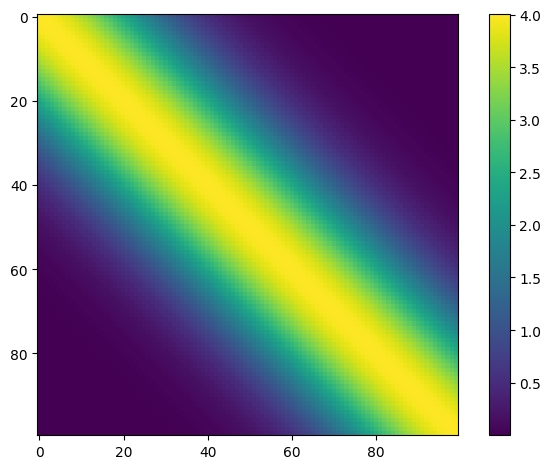

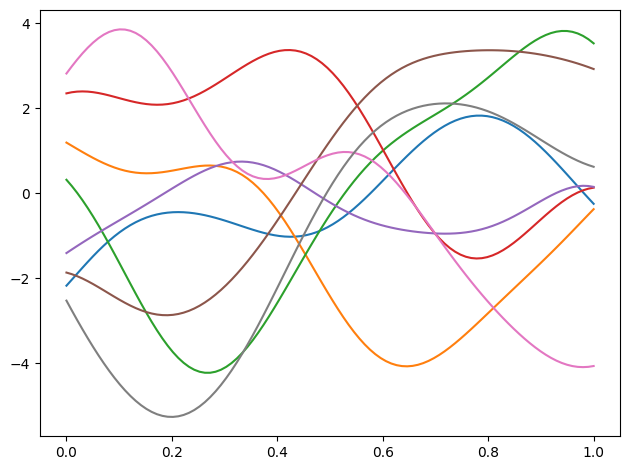

In [4]:
def sample(n=100):
    x = np.linspace(0, 1., n)
    # cov = kernel_cos(x, k=5.0) + np.eye(n)*1e-10
    cov = kernel_rbf(x, x, sig=2., l=0.2) + np.eye(n)*1e-10
    plt.imshow(cov); plt.colorbar();plt.tight_layout(); plt.show()
    L = np.linalg.cholesky(cov)
    # L_inv = numpy.linalg.inv(L)
    for i in range(8):
        rand_x = np.random.randn(len(x))[:, np.newaxis]
        y_ = L @ rand_x
        plt.plot(x, y_)
    plt.tight_layout()
    plt.show()
    
sample()

Then we constrain the first point to $(0, 0)$. From the $\mathcal{GP}$ we know the regression can be calculated as:
$$\mu^{*} = \boldsymbol{K}^* (\boldsymbol{K} + \sigma_n^2 \boldsymbol{I})^{-1} y $$.
$$ \mathrm{Cov}^{*} = \boldsymbol{K}^{**} - \boldsymbol{K}^{*}  \cdot (\boldsymbol{K} + \sigma_n^2 \boldsymbol{I})^{-1} \cdot \boldsymbol{K}^{*T}$$
where the $\sigma_n^2$ is the noise. In this tutorial, we won't introduce the noise. So $\sigma_n^2 = 0$.
Then we can apply the `sample` process.

In [6]:
def sample_with_constraints(n=100):
    x = np.linspace(0, 1., n)
    # cov = kernel_cos(x, k=5.0) + np.eye(n)*1e-10
    cov = kernel_rbf(x, x, sig=2., l=0.2) + np.eye(n)*1e-10

    # add the first constraints to the regression
    n_train = 1
    x_train = np.array([0]).reshape(-1, 1)
    y_train = np.array([0]).reshape(-1, 1)

    k_train = kernel_rbf(x_train, x_train, sig=2., l=0.2)
    # K_train_inv = np.linalg.inv(k_train)
    # K_train_det = np.linalg.det(k_train)
    L = np.linalg.cholesky(k_train + np.eye(n_train)*1e-10)
    k_half = kernel_rbf(x, x_train, sig=2., l=0.2)
    alph = np.linalg.solve(L, np.linalg.solve(L.T, y_train))
    v = np.linalg.solve(L, k_half.T)
    mean_regress = k_half@ alph
    print('Mean from regression is', mean_regress.squeeze())
    kernel_train = cov - v.T@v
    plt.imshow(kernel_train);plt.colorbar();plt.tight_layout();plt.show()
    L = np.linalg.cholesky(kernel_train + np.eye(n)*1e-10)

    for i in range(2):
        rand_x = np.random.randn(len(x))[:, np.newaxis] 
        y_ = L @ rand_x+ mean_regress
        plt.plot(x, y_, label='home-made')

    for i in range(2):
        y_ = np.random.multivariate_normal(mean=np.zeros(n), cov=kernel_train)
        plt.plot(x, y_, 'r.', label='numpy-func')
    plt.legend(); plt.tight_layout();plt.show()

sample_with_constraints()


KeyboardInterrupt: 